In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IsingSolutions import ising2d_exact, ising3d_monte_carlo as ising3d_mc
from TNModels import AKLT3D
from scipy.interpolate import interp1d,PchipInterpolator
from glob import glob
import numpy as np
import os
from tqdm.auto import tqdm


In [2]:
task_name='AKLT3D_X10'
critical_params={'a1':np.sqrt(20/15),'a2':np.sqrt(20/6),'a3':np.sqrt(20/1)}
ylim=[0,3]
scan_log=True

# task_name='AKLTDiamond_X10'
# critical_params={'a1':np.sqrt(6/4),'a2':np.sqrt(6/1)}
# ylim=[0,4]
# scan_log=False


# task_name='AKLT2D_X24'
# critical_params={'a1':np.sqrt(6/4),'a2':np.sqrt(6/1)}
# ylim=[0,2]
# scan_log=False

  0%|          | 0/81 [00:00<?, ?it/s]

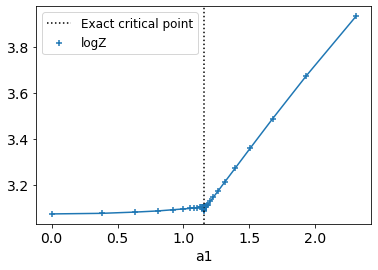

saved to ./data_output/AKLT3D_X10_scan_params/a1_logZ.png


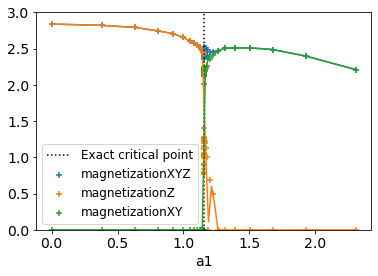

saved to ./data_output/AKLT3D_X10_scan_params/a1_magnetization.png


  0%|          | 0/81 [00:00<?, ?it/s]

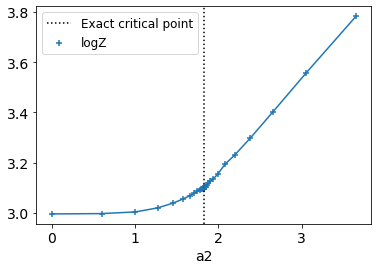

saved to ./data_output/AKLT3D_X10_scan_params/a2_logZ.png


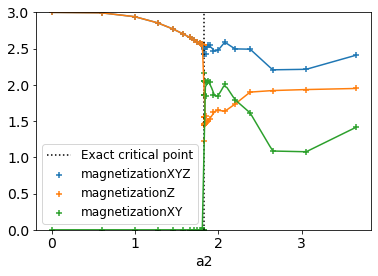

saved to ./data_output/AKLT3D_X10_scan_params/a2_magnetization.png


  0%|          | 0/81 [00:00<?, ?it/s]

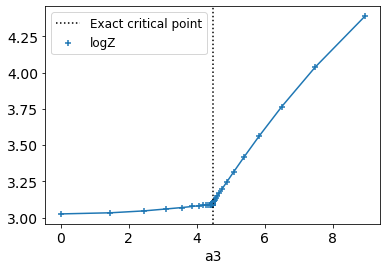

saved to ./data_output/AKLT3D_X10_scan_params/a3_logZ.png


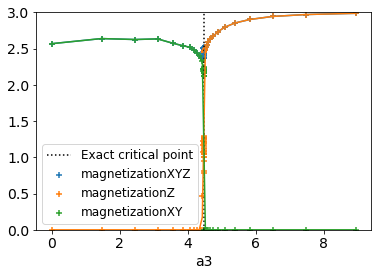

saved to ./data_output/AKLT3D_X10_scan_params/a3_magnetization.png


In [16]:
def plot_obs_by_layer(df,param_name,obs_name,exact_critical_param=None,exact_obs_func=None,ylim=None,xlim=None,max_layer=None,filename=None):
    beta_min,beta_max=df[param_name].min(),df[param_name].max()
    nLayers=df['iLayer'].max()+1
    if max_layer is not None: nLayers=min(nLayers,max_layer)
    iLayers=np.arange(2,nLayers,2)
    betas=np.linspace(beta_min,beta_max,100)
    if xlim: betas=np.linspace(max(xlim[0],beta_min),min(xlim[1],beta_max),100)
    cm=plt.get_cmap('jet')
    plt.rcParams.update({'font.size': 14,'legend.fontsize':10})
    fig=plt.figure(figsize=(6,4))
    plt.rcParams.update({'font.size': 14})
    plt.ylabel(obs_name)
    plt.xlabel(param_name)
    if exact_critical_param:
        plt.axvline(exact_critical_param,color='k',linestyle=':',label='Exact critical point')
    for iLayer in iLayers:
        df1=df[df['iLayer']==iLayer].sort_values(param_name)
        df1=df1[np.isfinite(df1[obs_name])]
        plt.plot(df1[param_name],df1[obs_name],'+',label='Layer %d'%iLayer,color=cm(iLayer/nLayers))
        # f1=PchipInterpolator(df1[param_name],df1[obs_name])
        f1=interp1d(df1[param_name],df1[obs_name],kind='linear',fill_value='extrapolate')
        plt.plot(betas,f1(betas),color=cm(iLayer/nLayers,alpha=.3))
    if callable(exact_obs_func):
        plt.plot(betas,exact_obs_func(betas),color='k',linestyle='--',label='Exact')
    elif isinstance(exact_obs_func,(float,int)):
        plt.axhline(exact_obs_func,color='k',linestyle='--',label='Exact')
    if ylim:plt.ylim(ylim)
    if xlim:plt.xlim(xlim)
    plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')

def plot_obs(df,param_name,obs_names,exact_critical_param=None,exact_obs_funcs=[],ylim=None,xlim=None,max_layer=None,filename=None):
    beta_min,beta_max=df[param_name].min(),df[param_name].max()
    nLayers=df['iLayer'].max()+1
    if max_layer is not None: nLayers=min(nLayers,max_layer)
    iLayer=nLayers-1
    betas=np.linspace(beta_min,beta_max,100)
    if xlim: betas=np.linspace(max(xlim[0],beta_min),min(xlim[1],beta_max),100)
    plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
    fig=plt.figure(figsize=(6,4))
    # plt.ylabel(obs_name)
    plt.xlabel(param_name)
    if exact_critical_param:
        plt.axvline(exact_critical_param,color='k',linestyle=':',label='Exact critical point')
    for i,obs_name in enumerate(obs_names):
        df1=df[df['iLayer']==iLayer].sort_values(param_name)
        df1=df1[np.isfinite(df1[obs_name])]
        # plt.plot(df1[param_name],df1[obs_name],'+',color=f'C{i}',label=obs_name)
        plt.scatter(df1[param_name],df1[obs_name],marker="+",color=f'C{i}',label=obs_name)
        f1=interp1d(df1[param_name],df1[obs_name],kind='linear',fill_value='extrapolate')
        plt.plot(betas,f1(betas),color=f'C{i}')
    for exact_obs_func in exact_obs_funcs:
        if callable(exact_obs_func):
            plt.plot(betas,exact_obs_func(betas),color='k',linestyle='--',label='Exact')
        elif isinstance(exact_obs_func,(float,int)):
            plt.axhline(exact_obs_func,color='k',linestyle='--',label='Exact')
    plt.legend()
    if ylim:plt.ylim(ylim)
    if xlim:plt.xlim(xlim)
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')

def load_df(filenames):
    filenames=sorted(filenames,key=lambda x:os.path.getmtime(x))
    dfs=[]
    for filename in tqdm(filenames):
        df=pd.read_csv(filename)
        dfs.append(df)
        # print(filename)
    df=pd.concat(dfs)
    df['magnetizationXY']=(df['magnetizationX']**2+df['magnetizationY']**2)**.5
    df['magnetizationXYZ']=(df['magnetizationX']**2+df['magnetizationY']**2+df['magnetizationZ']**2)**.5
    return df

os.makedirs('./data_output/'+task_name+'_scan_params/',exist_ok=True)
for param_name in critical_params.keys():
    namepart=param_name if not scan_log else param_name+'_log'
    df=load_df(glob(f'./data/{task_name}_scan_{namepart}/*/observables.csv'))
    df.to_csv(f'./data_output/{task_name}_scan_params/{param_name}.csv',index=False)
    exact_critical_param=critical_params[param_name]
    plot_obs(df,param_name,['logZ'],exact_critical_param,
                      filename=f'./data_output/{task_name}_scan_params/{param_name}_logZ.png')
    plot_obs(df,param_name,['magnetizationXYZ','magnetizationZ','magnetizationXY'],exact_critical_param,ylim=ylim,
                        filename=f'./data_output/{task_name}_scan_params/{param_name}_magnetization.png')